In [6]:
import tensorflow.examples.tutorials.mnist.input_data as input_data
mnist=input_data.read_data_sets("MNIST")

X_train=mnist.train.images
y_train=mnist.train.labels
X_test=mnist.test.images
y_test=mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST\train-labels-idx1-ubyte.gz
Extracting MNIST\t10k-images-idx3-ubyte.gz
Extracting MNIST\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from model_checkpoints/mnist_auto_encoder_var.ckpt
hidden3_sigma shape is  (10000, 20)oss:  1018878.85
xentropy shape is  (10000, 784)


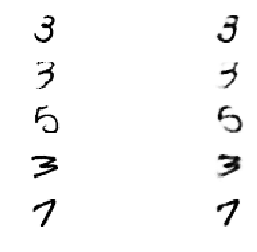

In [27]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
#MNIST
n_inputs=28*28
n_hidden1=300
n_hidden2=300
n_hidden3=20
n_hidden4=n_hidden2
n_hidden5=n_hidden1
n_outputs=n_inputs

n_epochs=3000
batch_size=200

learning_rate=0.01
l2_reg=0.000


#or use the handy tf dense function
tf.reset_default_graph()

activation=tf.nn.elu
regularizer=tf.contrib.layers.l2_regularizer(l2_reg)
initializer=tf.contrib.layers.variance_scaling_initializer()


X=tf.placeholder(tf.float32,shape=[None,n_inputs])


weights1_init=initializer([n_inputs,n_hidden1])
weights2_init=initializer([n_hidden1,n_hidden2])
weights3_init=initializer([n_hidden2,n_hidden3])
weights4_init=initializer([n_hidden3,n_hidden4])
weights5_init=initializer([n_hidden5,n_hidden5])
weights_out_init=initializer([n_hidden5,n_outputs])

weights1=tf.Variable(weights1_init,dtype=tf.float32,name="weights1")
weights2=tf.Variable(weights2_init,dtype=tf.float32,name="weights2")
weights3_mean=tf.Variable(weights3_init,dtype=tf.float32,name="weights3_mean")
weights3_sigma=tf.Variable(weights3_init,dtype=tf.float32,name="weights3_sigma")
weights4=tf.Variable(weights4_init,dtype=tf.float32,name="weights4")
weights5=tf.Variable(weights5_init,dtype=tf.float32,name="weights5")
weights_out=tf.Variable(weights_out_init,dtype=tf.float32,name="weights_out")

biases1=tf.Variable(tf.zeros(n_hidden1),name="biases1")
biases2=tf.Variable(tf.zeros(n_hidden2),name="biases2")
biases3_mean=tf.Variable(tf.zeros(n_hidden3),name="biases3_mean")
biases3_sigma=tf.Variable(tf.zeros(n_hidden3),name="biases3_sigma")
biases4=tf.Variable(tf.zeros(n_hidden4),name="biases4")
biases5=tf.Variable(tf.zeros(n_hidden5),name="biases5")
biases_out=tf.Variable(tf.zeros(n_outputs),name="biases_out")

with tf.device('/gpu:0'):
    hidden1=activation(tf.matmul(X,weights1)+biases1)
    hidden2=activation(tf.matmul(hidden1,weights2)+biases2)
    hidden3_mean=tf.matmul(hidden2,weights3_mean)+biases3_mean
    hidden3_sigma=tf.matmul(hidden2,weights3_sigma)+biases3_sigma
    noise=tf.random_normal(tf.shape(hidden3_sigma),dtype=tf.float32)
    hidden3=hidden3_mean+tf.exp(0.5*hidden3_sigma)*noise

with tf.device('/gpu:1'):    
    hidden4=activation(tf.matmul(hidden3,weights4)+biases4)
    hidden5=activation(tf.matmul(hidden4,weights5)+biases5)
    outputs_logit=tf.matmul(hidden5,weights_out)+biases_out
    outputs=tf.sigmoid(outputs_logit)

latent_loss=0.5*tf.reduce_sum(
tf.exp(hidden3_sigma)+tf.square(hidden3_mean)-1-hidden3_sigma)  #similarity to a normal distribution
xentropy=tf.nn.sigmoid_cross_entropy_with_logits(labels=X,logits=outputs_logit)
reconstruction_loss=tf.reduce_sum(xentropy)
loss=reconstruction_loss+latent_loss

optimizer=tf.train.AdadeltaOptimizer(learning_rate)
training_op=optimizer.minimize(loss)

init=tf.global_variables_initializer()
saver=tf.train.Saver()

n_test_digits=5
plot_list=np.random.choice(X_test.shape[0],n_test_digits, replace=False)
X_test_plot=X_test[plot_list]

with tf.Session() as sess:
    init.run()
    try:
        saver.restore(sess, "model_checkpoints/mnist_auto_encoder_var.ckpt")
    except:
        print("Model is not compatible with the checkpoint or does not exist")
        init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples//batch_size):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(training_op,feed_dict={X:X_batch})
        train_mse=loss.eval(feed_dict={X:X_train})
        test_mse=loss.eval(feed_dict={X:X_test})
        print(epoch,"Train Loss: ",train_mse," Test Loss: ",test_mse,end="\r")
    save_path=saver.save(sess,"model_checkpoints/mnist_auto_encoder_var.ckpt")
    outputs_val=outputs.eval(feed_dict={X:X_test_plot})
    print("hidden3_sigma shape is ",  (hidden3_sigma.eval(feed_dict={X:X_test})).shape)
    print("xentropy shape is ", (xentropy.eval(feed_dict={X:X_test})).shape)

def plot_image(image,shape=[28,28]):
    plt.imshow(image.reshape(shape),cmap="Greys",interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits,2,digit_index*2+1)
    plot_image(X_test_plot[digit_index])
    plt.subplot(n_test_digits,2,digit_index*2+2)
    plot_image(outputs_val[digit_index])

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Restoring parameters from model_checkpoints/mnist_auto_encoder_var.ckpt


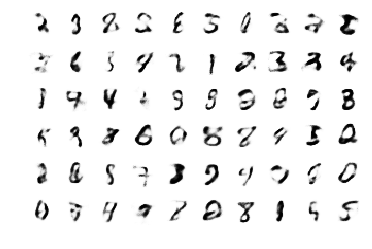

In [32]:
import tensorflow as tf
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
#MNIST
n_inputs=28*28
n_hidden1=300
n_hidden2=300
n_hidden3=20
n_hidden4=n_hidden2
n_hidden5=n_hidden1
n_outputs=n_inputs

n_epochs=3000
batch_size=200

learning_rate=0.01
l2_reg=0.000


#or use the handy tf dense function
tf.reset_default_graph()

activation=tf.nn.elu
regularizer=tf.contrib.layers.l2_regularizer(l2_reg)
initializer=tf.contrib.layers.variance_scaling_initializer()


X=tf.placeholder(tf.float32,shape=[None,n_inputs])


weights1_init=initializer([n_inputs,n_hidden1])
weights2_init=initializer([n_hidden1,n_hidden2])
weights3_init=initializer([n_hidden2,n_hidden3])
weights4_init=initializer([n_hidden3,n_hidden4])
weights5_init=initializer([n_hidden5,n_hidden5])
weights_out_init=initializer([n_hidden5,n_outputs])

weights1=tf.Variable(weights1_init,dtype=tf.float32,name="weights1")
weights2=tf.Variable(weights2_init,dtype=tf.float32,name="weights2")
weights3_mean=tf.Variable(weights3_init,dtype=tf.float32,name="weights3_mean")
weights3_sigma=tf.Variable(weights3_init,dtype=tf.float32,name="weights3_sigma")
weights4=tf.Variable(weights4_init,dtype=tf.float32,name="weights4")
weights5=tf.Variable(weights5_init,dtype=tf.float32,name="weights5")
weights_out=tf.Variable(weights_out_init,dtype=tf.float32,name="weights_out")

biases1=tf.Variable(tf.zeros(n_hidden1),name="biases1")
biases2=tf.Variable(tf.zeros(n_hidden2),name="biases2")
biases3_mean=tf.Variable(tf.zeros(n_hidden3),name="biases3_mean")
biases3_sigma=tf.Variable(tf.zeros(n_hidden3),name="biases3_sigma")
biases4=tf.Variable(tf.zeros(n_hidden4),name="biases4")
biases5=tf.Variable(tf.zeros(n_hidden5),name="biases5")
biases_out=tf.Variable(tf.zeros(n_outputs),name="biases_out")

with tf.device('/gpu:0'):
    hidden1=activation(tf.matmul(X,weights1)+biases1)
    hidden2=activation(tf.matmul(hidden1,weights2)+biases2)
    hidden3_mean=tf.matmul(hidden2,weights3_mean)+biases3_mean
    hidden3_sigma=tf.matmul(hidden2,weights3_sigma)+biases3_sigma
    noise=tf.random_normal(tf.shape(hidden3_sigma),dtype=tf.float32)
    hidden3=hidden3_mean+tf.exp(0.5*hidden3_sigma)*noise

with tf.device('/gpu:1'):    
    hidden4=activation(tf.matmul(hidden3,weights4)+biases4)
    hidden5=activation(tf.matmul(hidden4,weights5)+biases5)
    outputs_logit=tf.matmul(hidden5,weights_out)+biases_out
    outputs=tf.sigmoid(outputs_logit)

latent_loss=0.5*tf.reduce_sum(
tf.exp(hidden3_sigma)+tf.square(hidden3_mean)-1-hidden3_sigma)  #similarity to a normal distribution
xentropy=tf.nn.sigmoid_cross_entropy_with_logits(labels=X,logits=outputs_logit)
reconstruction_loss=tf.reduce_sum(xentropy)
loss=reconstruction_loss+latent_loss

optimizer=tf.train.AdadeltaOptimizer(learning_rate)
training_op=optimizer.minimize(loss)

init=tf.global_variables_initializer()
saver=tf.train.Saver()

n_test_digits=5
plot_list=np.random.choice(X_test.shape[0],n_test_digits, replace=False)
X_test_plot=X_test[plot_list]

n_digits=60

with tf.Session() as sess:
    init.run()
    try:
        saver.restore(sess, "model_checkpoints/mnist_auto_encoder_var.ckpt")
    except:
        print("Model is not compatible with the checkpoint or does not exist")
        init.run()
    coding_rnd=np.random.normal(size=[n_digits,n_hidden3])
    output_val=outputs.eval(feed_dict={hidden3:coding_rnd})

def plot_image(image,shape=[28,28]):
    plt.imshow(image.reshape(shape),cmap="Greys",interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_digits):
    plt.subplot(n_digits//10,10,digit_index+1)
    plot_image(output_val[digit_index])
